In [1]:
import sxs
import lal
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import argrelextrema
from scipy.interpolate import CubicSpline

/local/tmp/lpompili/ipykernel_3528852/3269727020.py:2: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


In [2]:
wf = sxs.load("SXS:BBH:1359")
reference_time = wf.metadata.reference_time
w = wf.h

hlm = w[:, w.index(2, 2)]

# Phase and instantaneous omega_22
phase_22 = - np.unwrap(np.angle(hlm))
omega_22 = np.gradient(phase_22, w.t)

# Find pericenters (maxima of omega_22) and apocenters (minima)
order = 50
idx_peri = argrelextrema(omega_22, np.greater, order=order)[0]
idx_apo = argrelextrema(omega_22, np.less, order=order)[0]

t_peri, phi_peri = w.t[idx_peri], phase_22[idx_peri]
t_apo, phi_apo = w.t[idx_apo], phase_22[idx_apo]

# Orbit-averaged omega_22 from consecutive pericenter pairs (Eq. 12)
t_avg_peri = (t_peri[:-1] + t_peri[1:]) / 2
omega_avg_peri = (phi_peri[1:] - phi_peri[:-1]) / (t_peri[1:] - t_peri[:-1])

# Same from consecutive apocenter pairs
t_avg_apo = (t_apo[:-1] + t_apo[1:]) / 2
omega_avg_apo = (phi_apo[1:] - phi_apo[:-1]) / (t_apo[1:] - t_apo[:-1])

# Union of both datasets, sorted by time
t_all = np.concatenate([t_avg_peri, t_avg_apo])
omega_all = np.concatenate([omega_avg_peri, omega_avg_apo])
sort_idx = np.argsort(t_all)
t_all, omega_all = t_all[sort_idx], omega_all[sort_idx]

# Cubic spline interpolant for <omega_22>(t)
omega_22_avg_spline = CubicSpline(t_all, omega_all)

Loading SXS simulations using latest tag 'v3.0.0', published at 2025-05-14T18:17:30Z.


In [3]:
Mtot = 80.0

# Evaluate at reference time
ref_idx = w.index_closest_to(reference_time)
t_ref = w.t[ref_idx]

omega_22_avg_ref = omega_22_avg_spline(t_ref)
omega_orb_avg_ref = omega_22_avg_ref / 2

print(f"Reference time: {t_ref:.1f} M")
print(f"<omega_orb>_ref = {omega_orb_avg_ref:.5f}")
print(f"<f_orb>_ref = {omega_orb_avg_ref / (Mtot * lal.MTSUN_SI * np.pi):.2f}")
print(50 * "=")

# Evaluate at time at which the tapering ends

t_end = t_ref + 500
omega_22_avg_end = omega_22_avg_spline(t_end)
omega_orb_avg_end = omega_22_avg_end / 2

print(f"Tapering end time: {t_end:.1f} M")
print(f"<omega_orb>_end = {omega_orb_avg_end:.5f}")
print(f"<f_orb>_end = {omega_orb_avg_end / (Mtot * lal.MTSUN_SI * np.pi):.2f}")

Reference time: 1483.8 M
<omega_orb>_ref = 0.02167
<f_orb>_ref = 17.51
Tapering end time: 1983.8 M
<omega_orb>_end = 0.02441
<f_orb>_end = 19.72


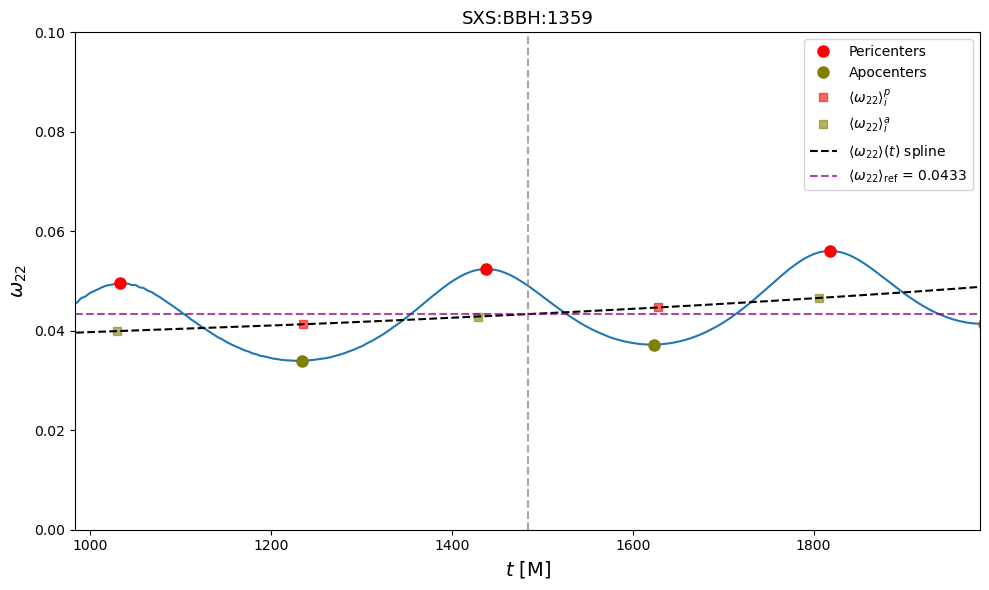

In [4]:
fig, ax = plt.subplots(figsize=(10, 6))

# Instantaneous omega_22
ax.plot(w.t, omega_22, color="C0")

# Pericenter / apocenter markers
ax.plot(t_peri, omega_22[idx_peri], "o", color="red", markersize=8, label="Pericenters")
ax.plot(t_apo, omega_22[idx_apo], "o", color="olive", markersize=8, label="Apocenters")

# Orbit-averaged data points
ax.plot(t_avg_peri, omega_avg_peri, "s", color="red", markersize=6, alpha=0.6, label=r"$\langle\omega_{22}\rangle^p_i$")
ax.plot(t_avg_apo, omega_avg_apo, "s", color="olive", markersize=6, alpha=0.6, label=r"$\langle\omega_{22}\rangle^a_i$")

# Cubic spline interpolant
t_dense = np.linspace(t_all[0], t_all[-1], 500)
ax.plot(t_dense, omega_22_avg_spline(t_dense), "k--", linewidth=1.5, label=r"$\langle\omega_{22}\rangle(t)$ spline")

# Reference time
ax.axvline(t_ref, color="gray", linestyle="--", alpha=0.7)
ax.axhline(omega_22_avg_ref, color="purple", linestyle="--", alpha=0.7,
           label=rf"$\langle\omega_{{22}}\rangle_\mathrm{{ref}}$ = {omega_22_avg_ref:.4f}")

margin = 500
ax.set_xlim(t_ref - margin, t_ref + margin)
ax.set_ylim(0.0, 0.1)
ax.set_xlabel(r"$t$ [M]", fontsize=14)
ax.set_ylabel(r"$\omega_{22}$", fontsize=14)
ax.set_title("SXS:BBH:1359", fontsize=13)
ax.legend(fontsize=10)
ax.set_ylim(bottom=0)
plt.tight_layout()
plt.show()